Autor:

Import bibliotek

In [1]:
import numpy as np
import os
import time
import random

if not os.path.exists('data'):
    os.makedirs('data')


In [2]:
# Komórka 2: Definicja parametrów symulacji

# Liczba plików do wygenerowania
num_files = 150

# Zakres temperatur warunków brzegowych (w °C)
temp_min = 0
temp_max = 300

# Liczba węzłów siatki (N)
num_nodes = 50

# Wartość tolerancji dla algorytmu MRS
tolerance = 0.5

# Współczynnik przewodzenia ciepła (aluminium)
kappa = 237.0  # [W/m·K]


In [3]:
# Komórka 3: Implementacja funkcji MRS do rozwiązania jednowymiarowego przepływu ciepła

def solve_heat_conduction_1D(TL, TR, N, tolerance, kappa):
    """
    Rozwiązywanie równania stacjonarnego przewodnictwa ciepła 1D metodą iteracyjną.
    
    Parametry:
    TL - temperatura na lewym końcu pręta
    TR - temperatura na prawym końcu pręta
    N - liczba węzłów w siatce
    tolerance - tolerancja zbieżności
    kappa - współczynnik przewodzenia ciepła (nie jest używany przy stacjonarnym rozkładzie bez źródeł)

    Zwraca:
    temperatures - tablica temperatur w węzłach
    iterations - liczba iteracji do osiągnięcia zbieżności
    """

    # Inicjalizacja tablicy temperatur: początkowo liniowa interpolacja między TL a TR
    temperatures = np.linspace(TL, TR, N)
    temperatures_new = temperatures.copy()

    # Ustawienie warunków brzegowych
    temperatures[0] = TL
    temperatures[-1] = TR

    iterations = 0
    max_diff = tolerance + 1  # Ustawienie wartości większej niż tolerancja na start

    while max_diff > tolerance:
        iterations += 1
        # Kopiowanie starego stanu
        temperatures_new[:] = temperatures[:]

        # Aktualizacja temperatury w każdym wewnętrznym węźle
        for i in range(1, N - 1):
            temperatures_new[i] = 0.5 * (temperatures[i - 1] + temperatures[i + 1])

        # Obliczenie maksymalnej zmiany
        max_diff = np.max(np.abs(temperatures_new - temperatures))

        # Aktualizacja stanu
        temperatures[:] = temperatures_new[:]

    return temperatures, iterations


In [4]:
# Komórka 4: Generator plików danych z pomiarem czasu

# Zainicjalizowanie zbioru do przechowywania użytych par warunków brzegowych
used_boundary_conditions = set()

# Rozpoczęcie pomiaru całkowitego czasu generacji
start_total_time = time.time()

# Petla generująca pliki
for file_idx in range(num_files):
    # Losowanie unikalnych warunków brzegowych
    while True:
        TL = random.randint(temp_min, temp_max)
        TR = random.randint(temp_min, temp_max)
        if (TL, TR) not in used_boundary_conditions:
            used_boundary_conditions.add((TL, TR))
            break

    # Rozpoczęcie pomiaru czasu pojedynczej symulacji
    start_single_time = time.time()

    # Rozwiązanie równania przepływu ciepła
    temperatures, iterations = solve_heat_conduction_1D(TL, TR, num_nodes, tolerance, kappa)

    # Zbudowanie nazwy pliku zgodnie z wymaganym formatem
    filename = f"{file_idx} {TL} {TR} {iterations}.txt"
    filepath = os.path.join('data', filename)

    # Zapis danych do pliku
    with open(filepath, 'w') as f:
        # Pierwsza linia: TL, TR, tolerance, iterations
        f.write(f"{TL},{TR},{tolerance},{iterations}\n")
        # Pozostałe linie: temperatury węzłów
        temperatures_str = ','.join([f"{temp:.6f}" for temp in temperatures])
        f.write(temperatures_str)

    # Pomiar czasu dla pojedynczego pliku
    end_single_time = time.time()
    elapsed_single = end_single_time - start_single_time
    print(f"Plik {filename} wygenerowany w {elapsed_single:.4f} sekund.")

# Pomiar całkowitego czasu
end_total_time = time.time()
elapsed_total = end_total_time - start_total_time
print(f"\nWszystkie pliki wygenerowane w {elapsed_total:.2f} sekund.")


Plik 0 153 211 1.txt wygenerowany w 0.0020 sekund.
Plik 1 152 272 1.txt wygenerowany w 0.0030 sekund.
Plik 2 3 297 1.txt wygenerowany w 0.0016 sekund.
Plik 3 210 80 1.txt wygenerowany w 0.0024 sekund.
Plik 4 145 222 1.txt wygenerowany w 0.0017 sekund.
Plik 5 293 175 1.txt wygenerowany w 0.0030 sekund.
Plik 6 261 256 1.txt wygenerowany w 0.0010 sekund.
Plik 7 3 70 1.txt wygenerowany w 0.0021 sekund.
Plik 8 53 199 1.txt wygenerowany w 0.0011 sekund.
Plik 9 112 23 1.txt wygenerowany w 0.0016 sekund.
Plik 10 112 142 1.txt wygenerowany w 0.0010 sekund.
Plik 11 50 250 1.txt wygenerowany w 0.0022 sekund.
Plik 12 276 180 1.txt wygenerowany w 0.0016 sekund.
Plik 13 164 28 1.txt wygenerowany w 0.0017 sekund.
Plik 14 197 47 1.txt wygenerowany w 0.0011 sekund.
Plik 15 96 48 1.txt wygenerowany w 0.0010 sekund.
Plik 16 113 246 1.txt wygenerowany w 0.0026 sekund.
Plik 17 267 16 1.txt wygenerowany w 0.0016 sekund.
Plik 18 194 291 1.txt wygenerowany w 0.0020 sekund.
Plik 19 124 273 1.txt wygenerowany w

In [5]:
# Komórka 5: Funkcja wczytująca dane z plików do macierzy wejść i wyjść

def load_data(data_directory, num_nodes):
    """
    Wczytywanie danych z plików .txt do macierzy wejściowych i wyjściowych.

    Parametry:
    data_directory - ścieżka do katalogu z plikami danych
    num_nodes - liczba węzłów siatki (rozmiar wektora temperatur)

    Zwraca:
    X_data - macierz cech wejściowych (TL, TR, tolerance, iterations)
    y_data - macierz wartości wyjściowych (temperatury w węzłach)
    """

    X_list = []
    y_list = []

    # Przeglądanie wszystkich plików w katalogu
    for filename in os.listdir(data_directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(data_directory, filename)
            with open(filepath, 'r') as f:
                # Pierwsza linia: cechy wejściowe
                first_line = f.readline().strip()
                TL, TR, tolerance, iterations = map(float, first_line.split(','))
                X_list.append([TL, TR, tolerance, iterations])

                # Druga linia: temperatury węzłów
                temperatures_line = f.readline().strip()
                temperatures = list(map(float, temperatures_line.split(',')))

                # Kontrola długości temperatur
                if len(temperatures) != num_nodes:
                    raise ValueError(f"Nieprawidłowa liczba temperatur w pliku {filename}")

                y_list.append(temperatures)

    # Konwersja list na tablice numpy
    X_data = np.array(X_list)
    y_data = np.array(y_list)

    return X_data, y_data

# Wywołanie funkcji dla katalogu 'data'
X_data, y_data = load_data('data', num_nodes)

print(f"Załadowano {X_data.shape[0]} próbek.")
print(f"Rozmiar X_data: {X_data.shape}")
print(f"Rozmiar y_data: {y_data.shape}")


Załadowano 150 próbek.
Rozmiar X_data: (150, 4)
Rozmiar y_data: (150, 50)


In [9]:
# Komórka 6: Budowa modelu sieci neuronowej (SSN)

from tensorflow import keras
from tensorflow.keras import layers as lyr

# Definicja modelu
model = keras.Sequential([
    lyr.Input(shape=(4,)),                    # Warstwa wejściowa: 4 cechy
    lyr.Dense(256, activation='relu'),         # Pierwsza warstwa ukryta
    lyr.Dense(512, activation='relu'),         # Druga warstwa ukryta
    lyr.Dense(num_nodes)                       # Warstwa wyjściowa: num_nodes neuronów (np. 50)
])

# Kompilacja modelu
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005),
              loss='mae')  # Funkcja straty: średni błąd bezwzględny (MAE)

# Wyświetlenie podsumowania modelu
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,514 (619.20 KB)

 Trainable params: 158,514 (619.20 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Komórka 7: Podział danych na zbiory treningowy i testowy, trenowanie modelu

from sklearn.model_selection import train_test_split

# Podział danych: 80% trening, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Trenowanie modelu
history = model.fit(
    X_train, y_train,
    validation_split=0.1,   # 10% danych treningowych jako walidacja
    epochs=100,
    batch_size=4,
    verbose=1
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 65.7260 - val_loss: 15.4173
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.7211 - val_loss: 6.9559
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7525 - val_loss: 5.8078
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2472 - val_loss: 7.5597
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6982 - val_loss: 7.7629
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2902 - val_loss: 6.1727
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.6012 - val_loss: 8.4068
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8139 - val_loss: 5.3390
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0682 - val_loss: 6.7219
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6945 - val_loss: 6.4956
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0944 - val_loss: 8.2828
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

In [13]:
# Komórka 8: Ocena modelu na danych testowych

# Ocena modelu na zbiorze testowym
test_loss = model.evaluate(X_test, y_test, verbose=1)

print(f"Średni błąd bezwzględny (MAE) na zbiorze testowym: {test_loss:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 3.4215
Średni błąd bezwzględny (MAE) na zbiorze testowym: 3.421454


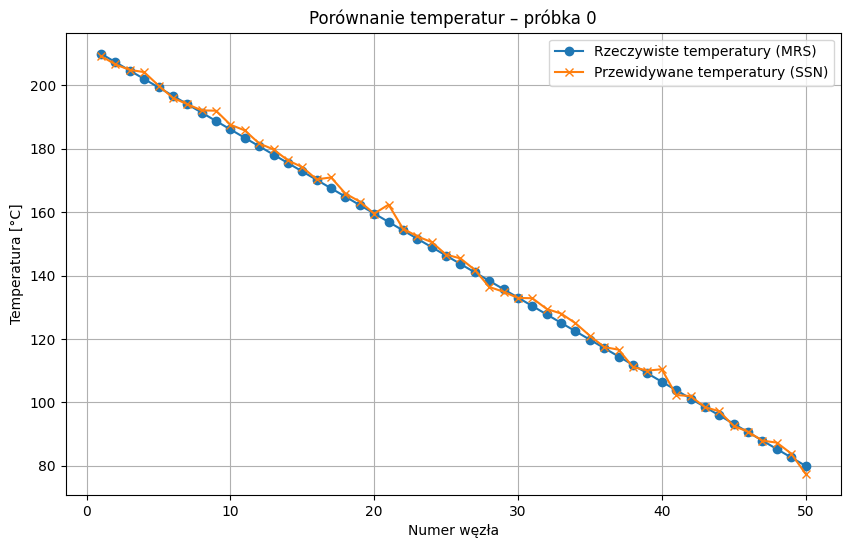

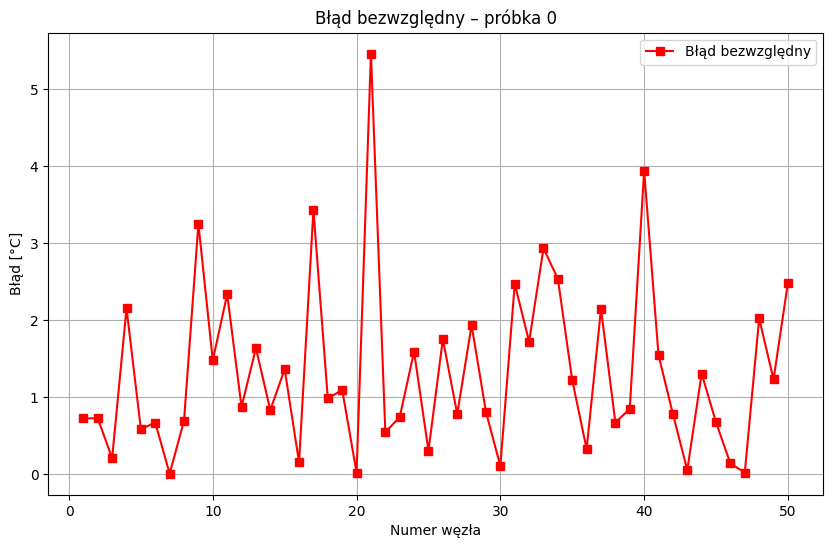

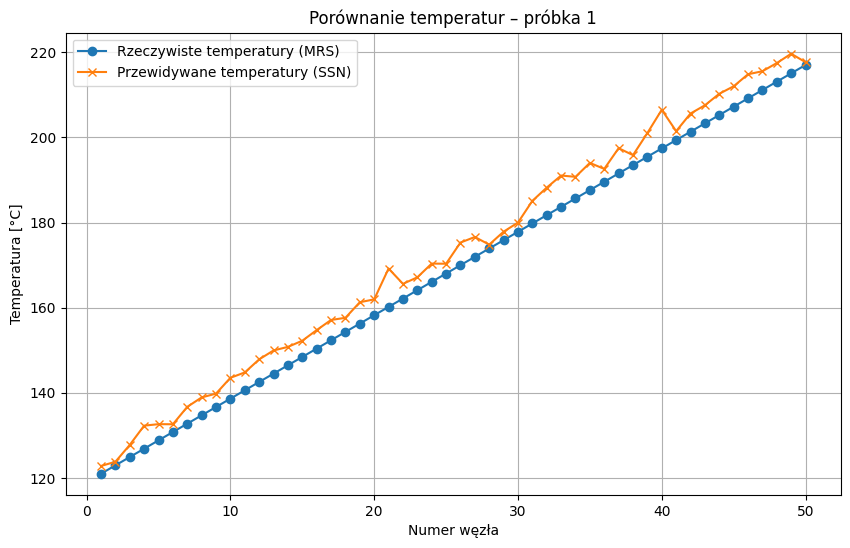

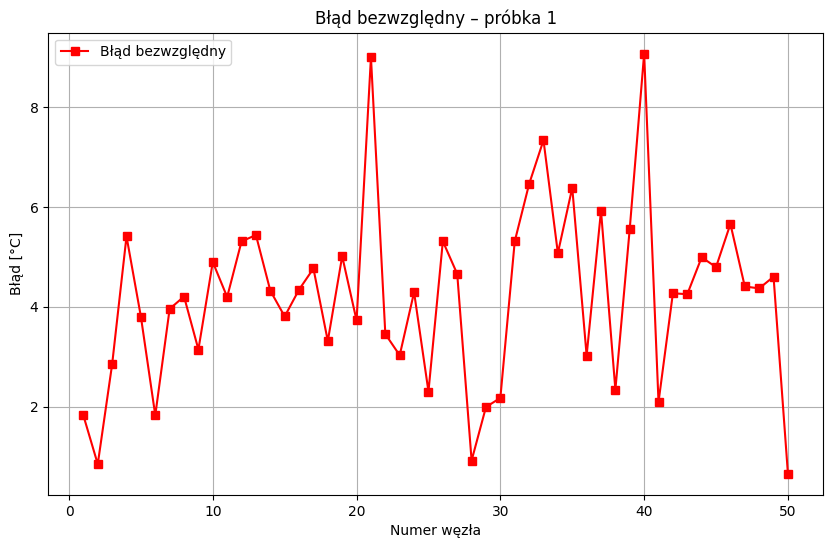

In [14]:
# Komórka 9: Wizualizacja wyników predykcji dla przykładowych próbek

import matplotlib.pyplot as plt

# Wybór dwóch przykładowych próbek z danych testowych
sample_indices = [0, 1]  # Indeksy dowolnie można zmieniać, np. 0 i 1
for idx in sample_indices:
    sample_input = X_test[idx].reshape(1, -1)  # Wymagany kształt (1, 4)
    
    true_temperatures = y_test[idx]
    predicted_temperatures = model.predict(sample_input, verbose=0).flatten()

    # Węzły (indeksy) materiału
    nodes = np.arange(1, num_nodes + 1)

    # Wykres rzeczywiste vs przewidywane temperatury
    plt.figure(figsize=(10, 6))
    plt.plot(nodes, true_temperatures, label='Rzeczywiste temperatury (MRS)', marker='o')
    plt.plot(nodes, predicted_temperatures, label='Przewidywane temperatury (SSN)', marker='x')
    plt.xlabel('Numer węzła')
    plt.ylabel('Temperatura [°C]')
    plt.title(f'Porównanie temperatur – próbka {idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Wykres błędów bezwzględnych
    absolute_errors = np.abs(true_temperatures - predicted_temperatures)

    plt.figure(figsize=(10, 6))
    plt.plot(nodes, absolute_errors, label='Błąd bezwzględny', marker='s', color='red')
    plt.xlabel('Numer węzła')
    plt.ylabel('Błąd [°C]')
    plt.title(f'Błąd bezwzględny – próbka {idx}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
# Komórka 10: Próba ulepszenia modelu - normalizacja wejść, nowa architektura, EarlyStopping

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Normalizacja cech wejściowych (X_data)
scaler = StandardScaler()
X_data_scaled = scaler.fit_transform(X_data)

# Ponowny podział danych po normalizacji
X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, y_data, test_size=0.2, random_state=42)

# Definicja ulepszonego modelu
improved_model = keras.Sequential([
    lyr.Input(shape=(4,)),
    lyr.Dense(512, activation='relu'),
    lyr.Dense(512, activation='relu'),
    lyr.Dense(256, activation='relu'),
    lyr.Dense(128, activation='relu'),
    lyr.Dense(num_nodes)  # Warstwa wyjściowa
])

# Kompilacja modelu z mniejszym learning rate
improved_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae'
)

# Konfiguracja EarlyStopping (zatrzymanie, gdy brak poprawy przez 20 epok)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Trenowanie ulepszonego modelu
history_improved = improved_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=300,
    batch_size=4,
    callbacks=[early_stopping],
    verbose=1
)

# Ocena modelu na zbiorze testowym
test_loss_improved = improved_model.evaluate(X_test, y_test, verbose=1)
print(f"Średni błąd bezwzględny (MAE) ulepszonego modelu na zbiorze testowym: {test_loss_improved:.6f}")


Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 144.1680 - val_loss: 117.7398
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 86.6799 - val_loss: 45.5283
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 46.1962 - val_loss: 40.3702
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 41.1267 - val_loss: 37.7638
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 37.2001 - val_loss: 36.5770
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 34.5119 - val_loss: 39.7844
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 33.5707 - val_loss: 35.9859
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 35.0680 - val_loss: 34.3440
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 33.3577 - val_loss: 36.6862
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 30.2371 - val_loss: 33.1047
Epoch 11/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 28.8261 - val_loss: 29.4035
Epoch 12/300
27/27 ━━━━━━━━━

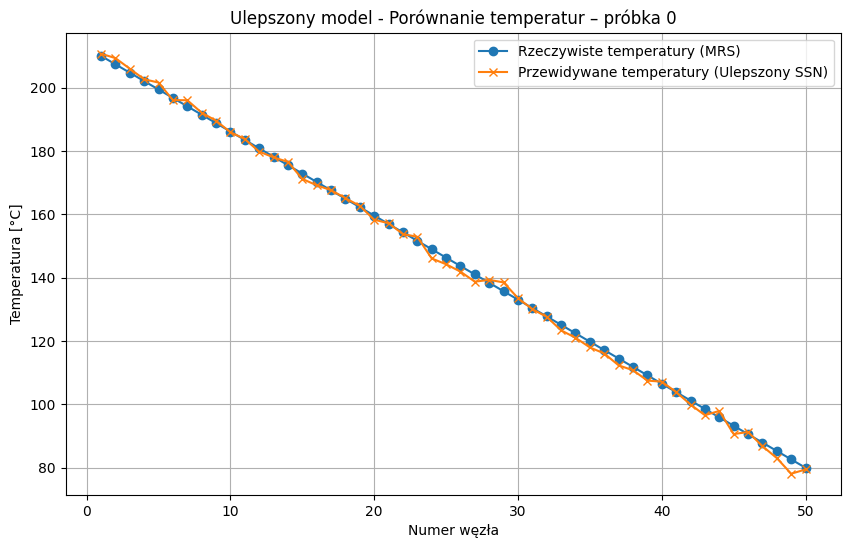

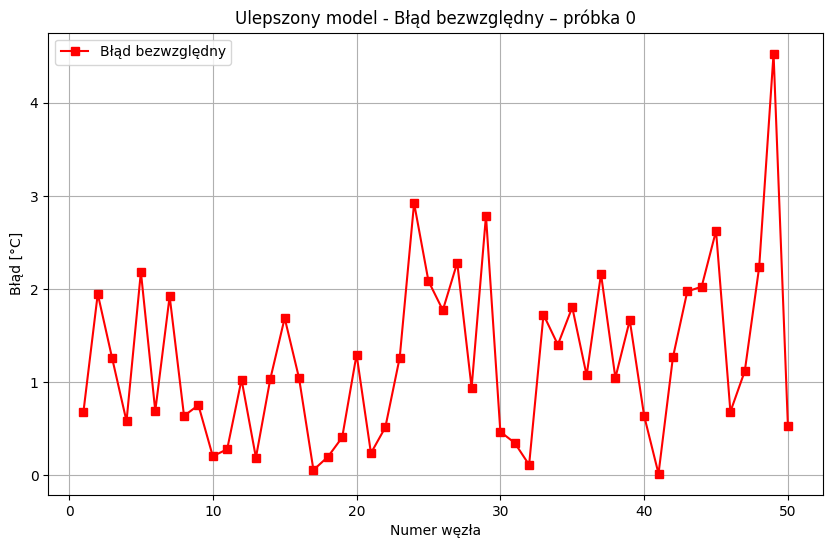

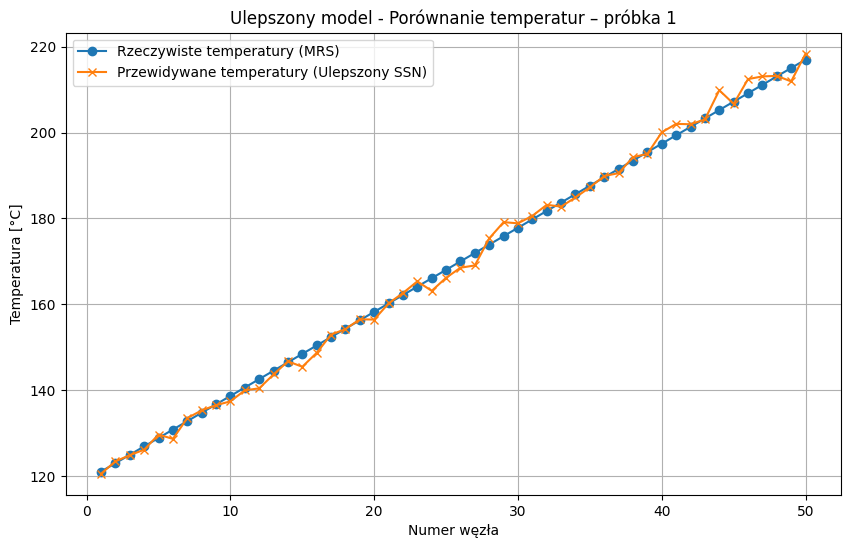

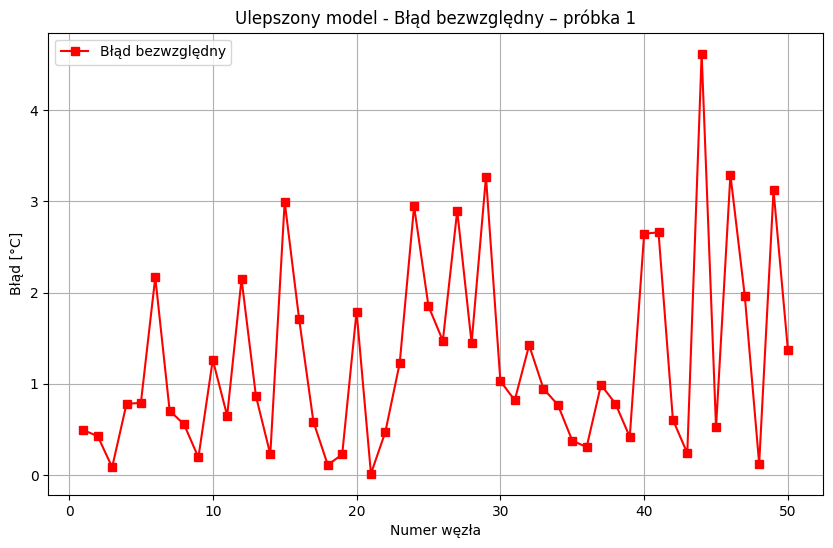

In [16]:
# Komórka 11: Wizualizacja wyników predykcji ulepszonego modelu

# Wybór dwóch przykładowych próbek ze zbioru testowego
sample_indices = [0, 1]  # Indeksy dowolne - można zmienić na inne

for idx in sample_indices:
    sample_input = X_test[idx].reshape(1, -1)  # Wymagany kształt (1, 4)
    
    true_temperatures = y_test[idx]
    predicted_temperatures = improved_model.predict(sample_input, verbose=0).flatten()

    # Węzły (indeksy) materiału
    nodes = np.arange(1, num_nodes + 1)

    # Wykres rzeczywiste vs przewidywane temperatury
    plt.figure(figsize=(10, 6))
    plt.plot(nodes, true_temperatures, label='Rzeczywiste temperatury (MRS)', marker='o')
    plt.plot(nodes, predicted_temperatures, label='Przewidywane temperatury (Ulepszony SSN)', marker='x')
    plt.xlabel('Numer węzła')
    plt.ylabel('Temperatura [°C]')
    plt.title(f'Ulepszony model - Porównanie temperatur – próbka {idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Wykres błędów bezwzględnych
    absolute_errors = np.abs(true_temperatures - predicted_temperatures)

    plt.figure(figsize=(10, 6))
    plt.plot(nodes, absolute_errors, label='Błąd bezwzględny', marker='s', color='red')
    plt.xlabel('Numer węzła')
    plt.ylabel('Błąd [°C]')
    plt.title(f'Ulepszony model - Błąd bezwzględny – próbka {idx}')
    plt.legend()
    plt.grid(True)
    plt.show()


### MOŻNA PRÓBOWAĆ DALEJ ULEPSZYĆ

2D

In [17]:
# Komórka 1: Import bibliotek i przygotowanie katalogu dla danych 2D

import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers as lyr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Utworzenie katalogu data2D jeśli nie istnieje
if not os.path.exists('data2D'):
    os.makedirs('data2D')


In [18]:
# Komórka 2: Definicja parametrów symulacji dla materiału 2D

# Liczba plików do wygenerowania
num_files_2D = 150

# Zakres temperatur warunków brzegowych (w °C)
temp_min_2D = 0
temp_max_2D = 300

# Rozmiar siatki (Nx x Ny)
Nx = 20  # liczba węzłów w kierunku x
Ny = 20  # liczba węzłów w kierunku y

# Całkowita liczba węzłów (do obliczenia wyjścia dla SSN)
num_nodes_2D = Nx * Ny

# Wartość tolerancji dla algorytmu MRS
tolerance_2D = 0.5

# Współczynnik przewodzenia ciepła (np. dla aluminium)
kappa_2D = 237.0  # [W/m·K]


In [19]:
# Komórka 3: Funkcja MRS do rozwiązania stacjonarnego przepływu ciepła w 2D

def solve_heat_conduction_2D(T_left, T_right, T_top, T_bottom, Nx, Ny, tolerance, kappa):
    """
    Rozwiązywanie równania stacjonarnego przewodnictwa ciepła 2D metodą iteracyjną.

    Parametry:
    T_left - temperatura na lewej krawędzi
    T_right - temperatura na prawej krawędzi
    T_top - temperatura na górnej krawędzi
    T_bottom - temperatura na dolnej krawędzi
    Nx - liczba węzłów w kierunku x
    Ny - liczba węzłów w kierunku y
    tolerance - tolerancja zbieżności
    kappa - współczynnik przewodzenia ciepła (nie jest bezpośrednio używany przy Laplace'u)

    Zwraca:
    temperatures - tablica Nx x Ny z temperaturami
    iterations - liczba iteracji do osiągnięcia zbieżności
    """

    # Inicjalizacja siatki temperatur
    temperatures = np.zeros((Nx, Ny))

    # Ustawienie warunków brzegowych
    temperatures[:, 0] = T_left    # lewa krawędź
    temperatures[:, -1] = T_right   # prawa krawędź
    temperatures[0, :] = T_top      # górna krawędź
    temperatures[-1, :] = T_bottom  # dolna krawędź

    # Kopia do aktualizacji
    temperatures_new = temperatures.copy()

    iterations = 0
    max_diff = tolerance + 1  # Ustawienie wartości większej niż tolerancja na start

    while max_diff > tolerance:
        iterations += 1
        temperatures_new[:, :] = temperatures[:, :]

        # Aktualizacja temperatur w węzłach wewnętrznych
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                temperatures_new[i, j] = 0.25 * (temperatures[i+1, j] + temperatures[i-1, j] +
                                                 temperatures[i, j+1] + temperatures[i, j-1])

        # Obliczenie maksymalnej zmiany
        max_diff = np.max(np.abs(temperatures_new - temperatures))

        # Aktualizacja stanu
        temperatures[:, :] = temperatures_new[:, :]

    return temperatures, iterations


In [20]:
# Komórka 4: Generator plików danych 2D z pomiarem czasu

# Inicjalizacja zbioru do przechowywania użytych warunków brzegowych
used_boundary_conditions_2D = set()

# Rozpoczęcie pomiaru całkowitego czasu generacji
start_total_time_2D = time.time()

# Pętla generująca pliki
for file_idx in range(num_files_2D):
    # Losowanie unikalnych warunków brzegowych (lewy, prawy, góra, dół)
    while True:
        T_left = random.randint(temp_min_2D, temp_max_2D)
        T_right = random.randint(temp_min_2D, temp_max_2D)
        T_top = random.randint(temp_min_2D, temp_max_2D)
        T_bottom = random.randint(temp_min_2D, temp_max_2D)
        boundary_key = (T_left, T_right, T_top, T_bottom)
        if boundary_key not in used_boundary_conditions_2D:
            used_boundary_conditions_2D.add(boundary_key)
            break

    # Rozpoczęcie pomiaru czasu pojedynczego pliku
    start_single_time_2D = time.time()

    # Rozwiązanie przepływu ciepła
    temperatures_2D, iterations_2D = solve_heat_conduction_2D(
        T_left, T_right, T_top, T_bottom,
        Nx, Ny, tolerance_2D, kappa_2D
    )

    # Zbudowanie nazwy pliku zgodnie z wymaganym formatem
    filename_2D = f"{file_idx} {T_left} {T_right} {T_top} {T_bottom} {iterations_2D}.txt"
    filepath_2D = os.path.join('data2D', filename_2D)

    # Zapis danych do pliku
    with open(filepath_2D, 'w') as f:
        # Pierwsza linia: warunki brzegowe i dodatkowe parametry
        f.write(f"{T_left},{T_right},{T_top},{T_bottom},{tolerance_2D},{iterations_2D}\n")
        # Wypisanie temperatur w siatce (w jednej linii, oddzielone przecinkami)
        temperatures_flat = temperatures_2D.flatten()
        temperatures_str = ','.join([f"{temp:.6f}" for temp in temperatures_flat])
        f.write(temperatures_str)

    # Pomiar czasu dla pojedynczego pliku
    end_single_time_2D = time.time()
    elapsed_single_2D = end_single_time_2D - start_single_time_2D
    print(f"Plik {filename_2D} wygenerowany w {elapsed_single_2D:.4f} sekund.")

# Pomiar całkowitego czasu
end_total_time_2D = time.time()
elapsed_total_2D = end_total_time_2D - start_total_time_2D
print(f"\nWszystkie pliki 2D wygenerowane w {elapsed_total_2D:.2f} sekund.")


Plik 0 5 276 138 156 136.txt wygenerowany w 0.1158 sekund.
Plik 1 77 4 244 110 116.txt wygenerowany w 0.0821 sekund.
Plik 2 29 118 279 148 136.txt wygenerowany w 0.1165 sekund.
Plik 3 225 71 41 209 132.txt wygenerowany w 0.1128 sekund.
Plik 4 221 244 236 39 154.txt wygenerowany w 0.1219 sekund.
Plik 5 199 51 237 231 152.txt wygenerowany w 0.1099 sekund.
Plik 6 269 105 109 122 139.txt wygenerowany w 0.1146 sekund.
Plik 7 147 97 211 101 133.txt wygenerowany w 0.0903 sekund.
Plik 8 274 278 41 181 157.txt wygenerowany w 0.1204 sekund.
Plik 9 51 253 292 18 141.txt wygenerowany w 0.1044 sekund.
Plik 10 45 191 238 249 152.txt wygenerowany w 0.1364 sekund.
Plik 11 15 195 136 71 113.txt wygenerowany w 0.0950 sekund.
Plik 12 287 76 235 177 157.txt wygenerowany w 0.1268 sekund.
Plik 13 298 221 55 237 161.txt wygenerowany w 0.1227 sekund.
Plik 14 73 8 227 168 122.txt wygenerowany w 0.0988 sekund.
Plik 15 83 258 86 12 117.txt wygenerowany w 0.1020 sekund.
Plik 16 53 45 184 289 135.txt wygenerowany 

In [21]:
# Komórka 5: Funkcja wczytująca dane z plików 2D

def load_data_2D(data_directory, Nx, Ny):
    """
    Wczytywanie danych z plików .txt 2D do macierzy wejść i wyjść.

    Parametry:
    data_directory - ścieżka do katalogu z plikami danych
    Nx - liczba węzłów w kierunku x
    Ny - liczba węzłów w kierunku y

    Zwraca:
    X_data - macierz cech wejściowych (T_left, T_right, T_top, T_bottom, tolerance, iterations)
    y_data - macierz wartości wyjściowych (rozłożone temperatury: Nx * Ny)
    """

    X_list = []
    y_list = []

    for filename in os.listdir(data_directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(data_directory, filename)
            with open(filepath, 'r') as f:
                # Pierwsza linia: cechy wejściowe
                first_line = f.readline().strip()
                T_left, T_right, T_top, T_bottom, tolerance, iterations = map(float, first_line.split(','))
                X_list.append([T_left, T_right, T_top, T_bottom, tolerance, iterations])

                # Druga linia: temperatury węzłów
                temperatures_line = f.readline().strip()
                temperatures_flat = list(map(float, temperatures_line.split(',')))

                # Kontrola długości danych
                if len(temperatures_flat) != Nx * Ny:
                    raise ValueError(f"Nieprawidłowa liczba temperatur w pliku {filename}")

                y_list.append(temperatures_flat)

    # Konwersja na tablice numpy
    X_data = np.array(X_list)
    y_data = np.array(y_list)

    return X_data, y_data

# Wywołanie funkcji dla katalogu 'data2D'
X_data_2D, y_data_2D = load_data_2D('data2D', Nx, Ny)

print(f"Załadowano {X_data_2D.shape[0]} próbek.")
print(f"Rozmiar X_data_2D: {X_data_2D.shape}")
print(f"Rozmiar y_data_2D: {y_data_2D.shape}")


Załadowano 150 próbek.
Rozmiar X_data_2D: (150, 6)
Rozmiar y_data_2D: (150, 400)


In [22]:
# Komórka 6: Budowa modelu sieci neuronowej dla 2D

# Definicja modelu
model_2D = keras.Sequential([
    lyr.Input(shape=(6,)),                   # Warstwa wejściowa: 6 cech (T_left, T_right, T_top, T_bottom, tolerance, iterations)
    lyr.Dense(512, activation='relu'),        # Warstwa ukryta 1
    lyr.Dense(512, activation='relu'),        # Warstwa ukryta 2
    lyr.Dense(256, activation='relu'),        # Warstwa ukryta 3
    lyr.Dense(128, activation='relu'),        # Warstwa ukryta 4
    lyr.Dense(Nx * Ny)                        # Warstwa wyjściowa: Nx * Ny neuronów (np. 400 dla 20x20)
])

# Kompilacja modelu
model_2D.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae'
)

# Wyświetlenie podsumowania modelu
model_2D.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 400)            │        51,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,064 (1.84 MB)

 Trainable params: 482,064 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Komórka 7: Podział danych i trenowanie modelu dla 2D

from tensorflow.keras.callbacks import EarlyStopping

# Normalizacja cech wejściowych (opcjonalnie - ale warto!)
scaler_2D = StandardScaler()
X_data_2D_scaled = scaler_2D.fit_transform(X_data_2D)

# Podział danych: 80% trening, 20% test
X_train_2D, X_test_2D, y_train_2D, y_test_2D = train_test_split(
    X_data_2D_scaled, y_data_2D, test_size=0.2, random_state=42
)

# Definicja EarlyStopping
early_stopping_2D = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Trenowanie modelu
history_2D = model_2D.fit(
    X_train_2D, y_train_2D,
    validation_split=0.1,   # 10% danych treningowych na walidację
    epochs=300,
    batch_size=4,
    callbacks=[early_stopping_2D],
    verbose=1
)


Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 138.8403 - val_loss: 88.3138
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 66.8011 - val_loss: 51.9337
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 46.6058 - val_loss: 45.7532
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 45.1812 - val_loss: 46.1543
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 44.5520 - val_loss: 43.7334
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 42.4560 - val_loss: 46.1842
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 43.5352 - val_loss: 44.3781
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 40.0183 - val_loss: 44.5295
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 40.2610 - val_loss: 41.9681
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 39.9870 - val_loss: 43.9984
Epoch 11/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 41.6375 - val_loss: 44.6002
Epoch 12/300
27/27 ━━━━━━━━━━

In [24]:
# Komórka 8: Ocena modelu na danych testowych 2D

# Ocena modelu na zbiorze testowym
test_loss_2D = model_2D.evaluate(X_test_2D, y_test_2D, verbose=1)

print(f"Średni błąd bezwzględny (MAE) na zbiorze testowym (2D): {test_loss_2D:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 3.2982
Średni błąd bezwzględny (MAE) na zbiorze testowym (2D): 3.298176


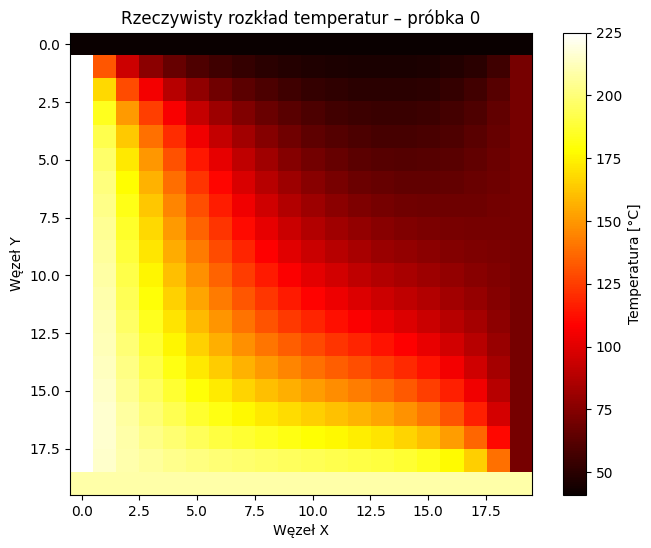

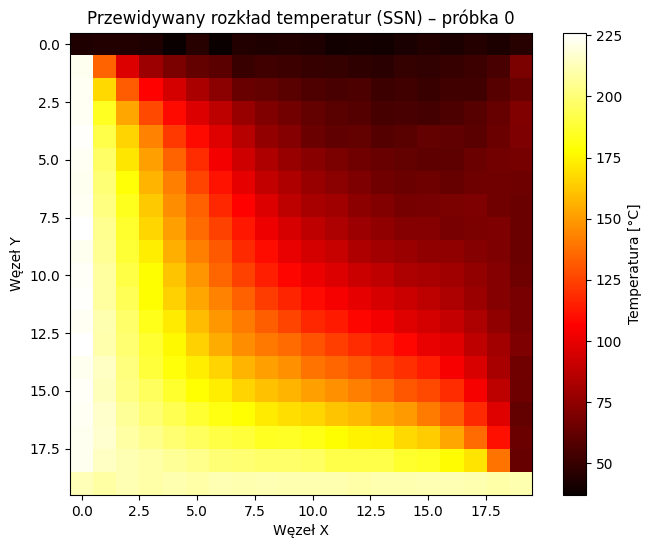

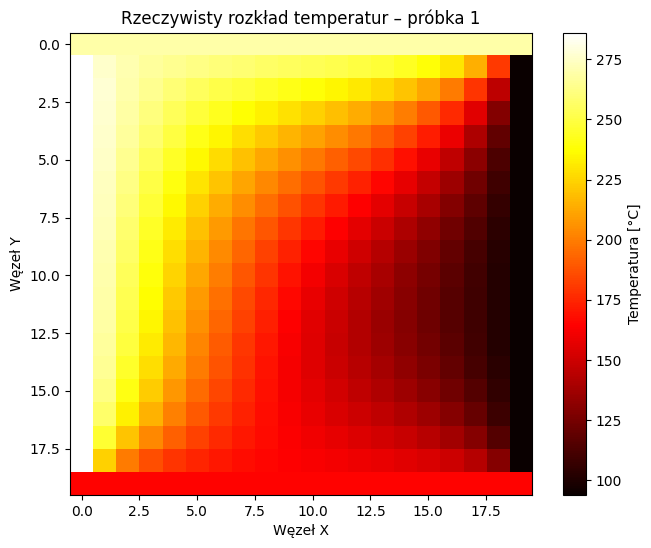

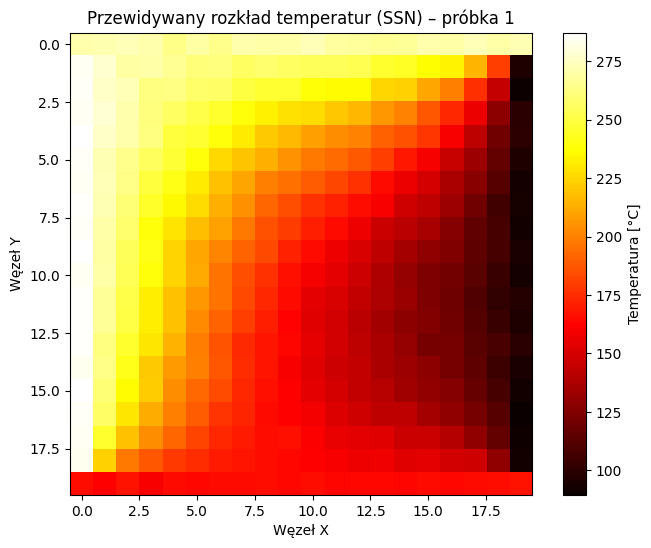

In [25]:
# Komórka 9: Wizualizacja wyników - mapy ciepła rzeczywistych i przewidywanych temperatur

# Wybór przykładowych indeksów z testowego zbioru
sample_indices_2D = [0, 1]  # Indeksy próbek do pokazania (dowolnie można zmieniać)

for idx in sample_indices_2D:
    sample_input = X_test_2D[idx].reshape(1, -1)

    true_temperatures = y_test_2D[idx].reshape(Nx, Ny)
    predicted_temperatures = model_2D.predict(sample_input, verbose=0).flatten().reshape(Nx, Ny)

    # Wykres rzeczywistego rozkładu temperatur (heatmapa)
    plt.figure(figsize=(8, 6))
    plt.imshow(true_temperatures, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Temperatura [°C]')
    plt.title(f'Rzeczywisty rozkład temperatur – próbka {idx}')
    plt.xlabel('Węzeł X')
    plt.ylabel('Węzeł Y')
    plt.show()

    # Wykres przewidywanego rozkładu temperatur (heatmapa)
    plt.figure(figsize=(8, 6))
    plt.imshow(predicted_temperatures, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Temperatura [°C]')
    plt.title(f'Przewidywany rozkład temperatur (SSN) – próbka {idx}')
    plt.xlabel('Węzeł X')
    plt.ylabel('Węzeł Y')
    plt.show()


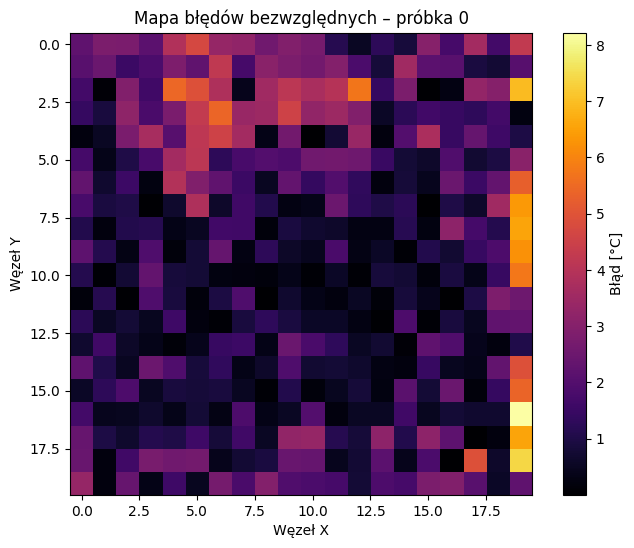

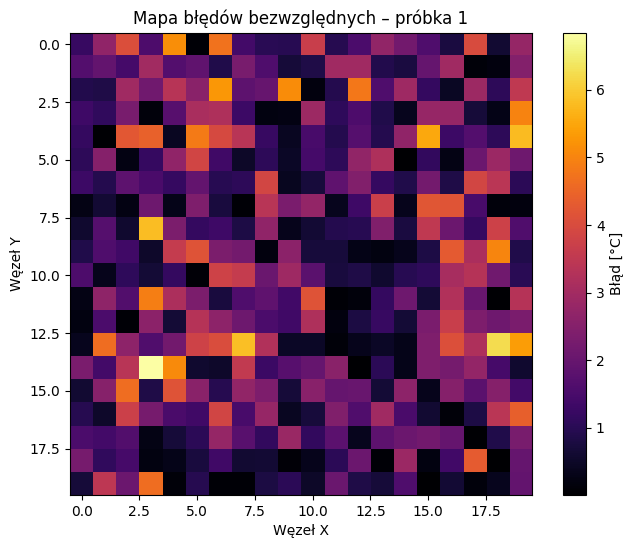

In [26]:
# Komórka 10: Wizualizacja błędów bezwzględnych (różnica rzeczywiste vs przewidywane)

# Wybór tych samych próbek co wcześniej
sample_indices_2D = [0, 1]  # Te same indeksy co w Komórce 9

for idx in sample_indices_2D:
    sample_input = X_test_2D[idx].reshape(1, -1)

    true_temperatures = y_test_2D[idx].reshape(Nx, Ny)
    predicted_temperatures = model_2D.predict(sample_input, verbose=0).flatten().reshape(Nx, Ny)

    # Obliczenie macierzy błędów bezwzględnych
    absolute_errors = np.abs(true_temperatures - predicted_temperatures)

    # Wykres błędów bezwzględnych
    plt.figure(figsize=(8, 6))
    plt.imshow(absolute_errors, cmap='inferno', interpolation='nearest')
    plt.colorbar(label='Błąd [°C]')
    plt.title(f'Mapa błędów bezwzględnych – próbka {idx}')
    plt.xlabel('Węzeł X')
    plt.ylabel('Węzeł Y')
    plt.show()


### Można sprobować ulepszyć

In [27]:
# Komórka 1: Import bibliotek

import numpy as np
import matplotlib.pyplot as plt
import os
import time

from tensorflow import keras
from tensorflow.keras import layers as lyr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [28]:
# Komórka 2: Wczytanie danych 1D do zadania odwrotnego (BACK)

def load_data_BACK_1D(data_directory, num_nodes):
    """
    Wczytywanie danych z plików .txt do zadania odwrotnego 1D.

    Parametry:
    data_directory - ścieżka do katalogu z plikami danych
    num_nodes - liczba węzłów siatki

    Zwraca:
    X_data - macierz wejść (rozkład temperatury)
    y_data - macierz wyjść (TL, TR)
    """
    X_list = []
    y_list = []

    for filename in os.listdir(data_directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(data_directory, filename)
            with open(filepath, 'r') as f:
                # Pierwsza linia: cechy wejściowe
                first_line = f.readline().strip()
                TL, TR, tolerance, iterations = map(float, first_line.split(','))

                # Druga linia: temperatury
                temperatures_line = f.readline().strip()
                temperatures = list(map(float, temperatures_line.split(',')))

                if len(temperatures) != num_nodes:
                    raise ValueError(f"Nieprawidłowa liczba temperatur w pliku {filename}")

                # Do wejścia: cały rozkład temperatur
                X_list.append(temperatures)
                # Do wyjścia: TL i TR
                y_list.append([TL, TR])

    X_data = np.array(X_list)
    y_data = np.array(y_list)

    return X_data, y_data

# Wywołanie funkcji dla katalogu 'data'
X_data_back_1D, y_data_back_1D = load_data_BACK_1D('data', num_nodes)

print(f"Załadowano {X_data_back_1D.shape[0]} próbek.")
print(f"Rozmiar X_data_back_1D: {X_data_back_1D.shape}")
print(f"Rozmiar y_data_back_1D: {y_data_back_1D.shape}")


Załadowano 150 próbek.
Rozmiar X_data_back_1D: (150, 50)
Rozmiar y_data_back_1D: (150, 2)


In [29]:
# Komórka 3: Przygotowanie danych (normalizacja) i budowa modelu SSN do odtwarzania TL i TR

# Normalizacja danych wejściowych (temperatury w materiale)
scaler_back_1D = StandardScaler()
X_data_back_1D_scaled = scaler_back_1D.fit_transform(X_data_back_1D)

# Podział danych na zbiór treningowy i testowy (80% / 20%)
X_train_back_1D, X_test_back_1D, y_train_back_1D, y_test_back_1D = train_test_split(
    X_data_back_1D_scaled, y_data_back_1D, test_size=0.2, random_state=42
)

# Budowa modelu SSN do odtwarzania warunków brzegowych
model_back_1D = keras.Sequential([
    lyr.Input(shape=(num_nodes,)),        # Wejście: num_nodes temperatur
    lyr.Dense(256, activation='relu'),     # Warstwa ukryta 1
    lyr.Dense(512, activation='relu'),     # Warstwa ukryta 2
    lyr.Dense(2)                           # Wyjście: TL i TR (2 wartości)
])

# Kompilacja modelu
model_back_1D.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae'
)

# Wyświetlenie podsumowania modelu
model_back_1D.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,666 (569.01 KB)

 Trainable params: 145,666 (569.01 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Komórka 4: Trenowanie modelu SSN do odtwarzania warunków brzegowych (BACK 1D)

from tensorflow.keras.callbacks import EarlyStopping

# Definicja EarlyStopping
early_stopping_back_1D = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Trenowanie modelu
history_back_1D = model_back_1D.fit(
    X_train_back_1D, y_train_back_1D,
    validation_split=0.1,    # 10% danych treningowych na walidację
    epochs=300,
    batch_size=4,
    callbacks=[early_stopping_back_1D],
    verbose=1
)


Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 151.3959 - val_loss: 118.7689
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 98.9878 - val_loss: 70.7492
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 68.2296 - val_loss: 44.3128
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 45.5233 - val_loss: 27.4505
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 39.7601 - val_loss: 23.7353
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 34.7705 - val_loss: 25.8888
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 31.2718 - val_loss: 33.5518
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33.4647 - val_loss: 22.4536
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 32.2530 - val_loss: 29.6097
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 33.2293 - val_loss: 26.7446
Epoch 11/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 35.1183 - val_loss: 26.5436
Epoch 12/300
27/27 ━━━━━━━━━━━━━━━━

In [31]:
# Komórka 5: Ocena modelu SSN (BACK 1D) na danych testowych

# Ocena modelu na zbiorze testowym
test_loss_back_1D = model_back_1D.evaluate(X_test_back_1D, y_test_back_1D, verbose=1)

print(f"Średni błąd bezwzględny (MAE) na zbiorze testowym (BACK 1D): {test_loss_back_1D:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 1.7923
Średni błąd bezwzględny (MAE) na zbiorze testowym (BACK 1D): 1.792261


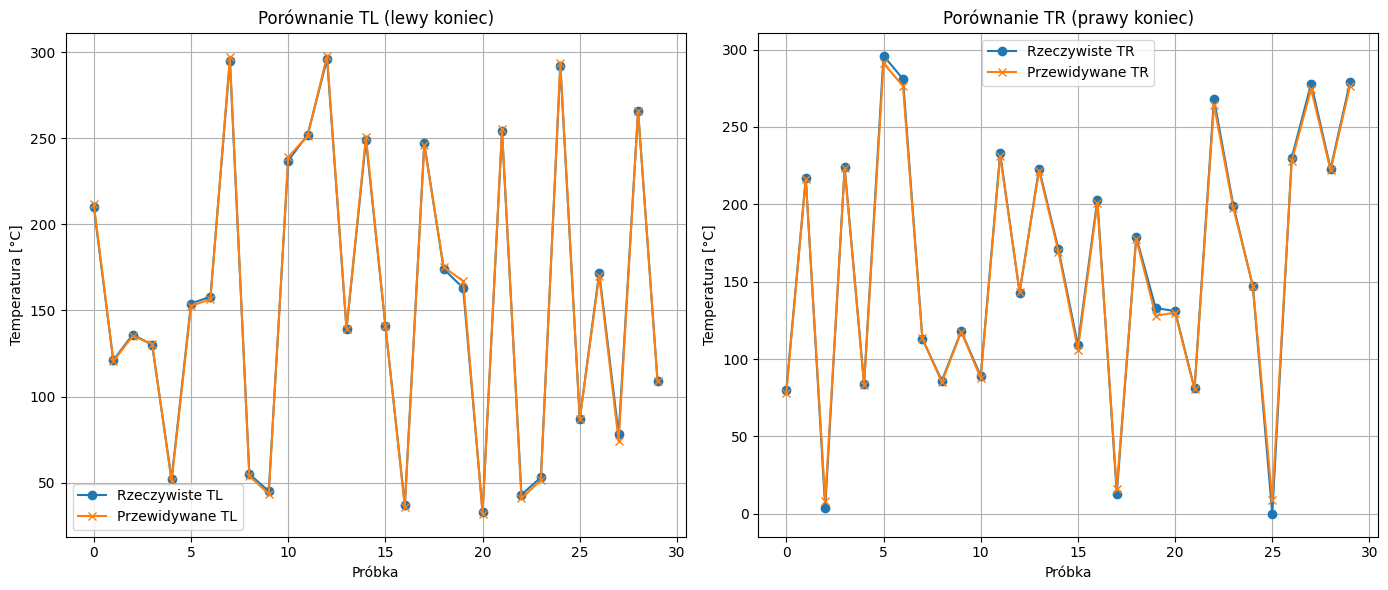

In [32]:
# Komórka 6: Wykresy - porównanie przewidywanych i rzeczywistych warunków brzegowych (BACK 1D)

# Przewidywanie warunków brzegowych dla danych testowych
y_pred_back_1D = model_back_1D.predict(X_test_back_1D, verbose=0)

# Rysowanie wykresów dla TL i TR osobno
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wykres dla TL
axes[0].plot(y_test_back_1D[:, 0], label='Rzeczywiste TL', marker='o')
axes[0].plot(y_pred_back_1D[:, 0], label='Przewidywane TL', marker='x')
axes[0].set_title('Porównanie TL (lewy koniec)')
axes[0].set_xlabel('Próbka')
axes[0].set_ylabel('Temperatura [°C]')
axes[0].legend()
axes[0].grid(True)

# Wykres dla TR
axes[1].plot(y_test_back_1D[:, 1], label='Rzeczywiste TR', marker='o')
axes[1].plot(y_pred_back_1D[:, 1], label='Przewidywane TR', marker='x')
axes[1].set_title('Porównanie TR (prawy koniec)')
axes[1].set_xlabel('Próbka')
axes[1].set_ylabel('Temperatura [°C]')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [33]:
# Komórka 7: Wczytanie danych 2D do zadania odwrotnego (BACK 2D)

def load_data_BACK_2D(data_directory, Nx, Ny):
    """
    Wczytywanie danych z plików .txt do zadania odwrotnego 2D.

    Parametry:
    data_directory - ścieżka do katalogu z plikami danych
    Nx, Ny - liczba węzłów w siatce 2D

    Zwraca:
    X_data - macierz wejść (rozkład temperatury)
    y_data - macierz wyjść (T_left, T_right, T_top, T_bottom)
    """

    X_list = []
    y_list = []

    for filename in os.listdir(data_directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(data_directory, filename)
            with open(filepath, 'r') as f:
                # Pierwsza linia: cechy wejściowe
                first_line = f.readline().strip()
                T_left, T_right, T_top, T_bottom, tolerance, iterations = map(float, first_line.split(','))

                # Druga linia: temperatury (flattened)
                temperatures_line = f.readline().strip()
                temperatures = list(map(float, temperatures_line.split(',')))

                if len(temperatures) != Nx * Ny:
                    raise ValueError(f"Nieprawidłowa liczba temperatur w pliku {filename}")

                X_list.append(temperatures)
                y_list.append([T_left, T_right, T_top, T_bottom])

    X_data = np.array(X_list)
    y_data = np.array(y_list)

    return X_data, y_data

# Wczytanie danych 2D z katalogu 'data2D'
X_data_back_2D, y_data_back_2D = load_data_BACK_2D('data2D', Nx, Ny)

print(f"Załadowano {X_data_back_2D.shape[0]} próbek.")
print(f"Rozmiar X_data_back_2D: {X_data_back_2D.shape}")
print(f"Rozmiar y_data_back_2D: {y_data_back_2D.shape}")


Załadowano 150 próbek.
Rozmiar X_data_back_2D: (150, 400)
Rozmiar y_data_back_2D: (150, 4)


In [34]:
# Komórka 8: Przygotowanie danych (normalizacja) i budowa modelu SSN do odtwarzania warunków brzegowych (BACK 2D)

# Normalizacja danych wejściowych (temperatury w materiale 2D)
scaler_back_2D = StandardScaler()
X_data_back_2D_scaled = scaler_back_2D.fit_transform(X_data_back_2D)

# Podział danych na zbiór treningowy i testowy (80% / 20%)
X_train_back_2D, X_test_back_2D, y_train_back_2D, y_test_back_2D = train_test_split(
    X_data_back_2D_scaled, y_data_back_2D, test_size=0.2, random_state=42
)

# Budowa modelu SSN do odtwarzania warunków brzegowych 2D
model_back_2D = keras.Sequential([
    lyr.Input(shape=(Nx * Ny,)),          # Wejście: Nx * Ny temperatur
    lyr.Dense(512, activation='relu'),    # Warstwa ukryta 1
    lyr.Dense(512, activation='relu'),    # Warstwa ukryta 2
    lyr.Dense(256, activation='relu'),    # Warstwa ukryta 3
    lyr.Dense(128, activation='relu'),    # Warstwa ukryta 4
    lyr.Dense(4)                          # Wyjście: T_left, T_right, T_top, T_bottom
])

# Kompilacja modelu
model_back_2D.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae'
)

# Wyświetlenie podsumowania modelu
model_back_2D.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 632,708 (2.41 MB)

 Trainable params: 632,708 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Komórka 9: Trenowanie modelu SSN do odtwarzania warunków brzegowych (BACK 2D)

# Definicja EarlyStopping
early_stopping_back_2D = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Trenowanie modelu
history_back_2D = model_back_2D.fit(
    X_train_back_2D, y_train_back_2D,
    validation_split=0.1,    # 10% danych treningowych na walidację
    epochs=300,
    batch_size=4,
    callbacks=[early_stopping_back_2D],
    verbose=1
)


Epoch 1/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 127.8215 - val_loss: 78.3354
Epoch 2/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 72.2833 - val_loss: 69.8685
Epoch 3/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 54.8042 - val_loss: 48.4441
Epoch 4/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 37.6896 - val_loss: 25.5904
Epoch 5/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 28.4677 - val_loss: 32.8870
Epoch 6/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 29.5816 - val_loss: 22.3010
Epoch 7/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 26.1540 - val_loss: 29.1522
Epoch 8/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 29.5060 - val_loss: 23.6314
Epoch 9/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28.0217 - val_loss: 26.4724
Epoch 10/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 34.8966 - val_loss: 28.8184
Epoch 11/300
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28.0458 - val_loss: 29.2615
Epoch 12/300
27/27 ━━━━━━━━━━

In [36]:
# Komórka 10: Ocena modelu SSN (BACK 2D) na danych testowych

# Ocena modelu na zbiorze testowym
test_loss_back_2D = model_back_2D.evaluate(X_test_back_2D, y_test_back_2D, verbose=1)

print(f"Średni błąd bezwzględny (MAE) na zbiorze testowym (BACK 2D): {test_loss_back_2D:.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 26.6836
Średni błąd bezwzględny (MAE) na zbiorze testowym (BACK 2D): 26.683552


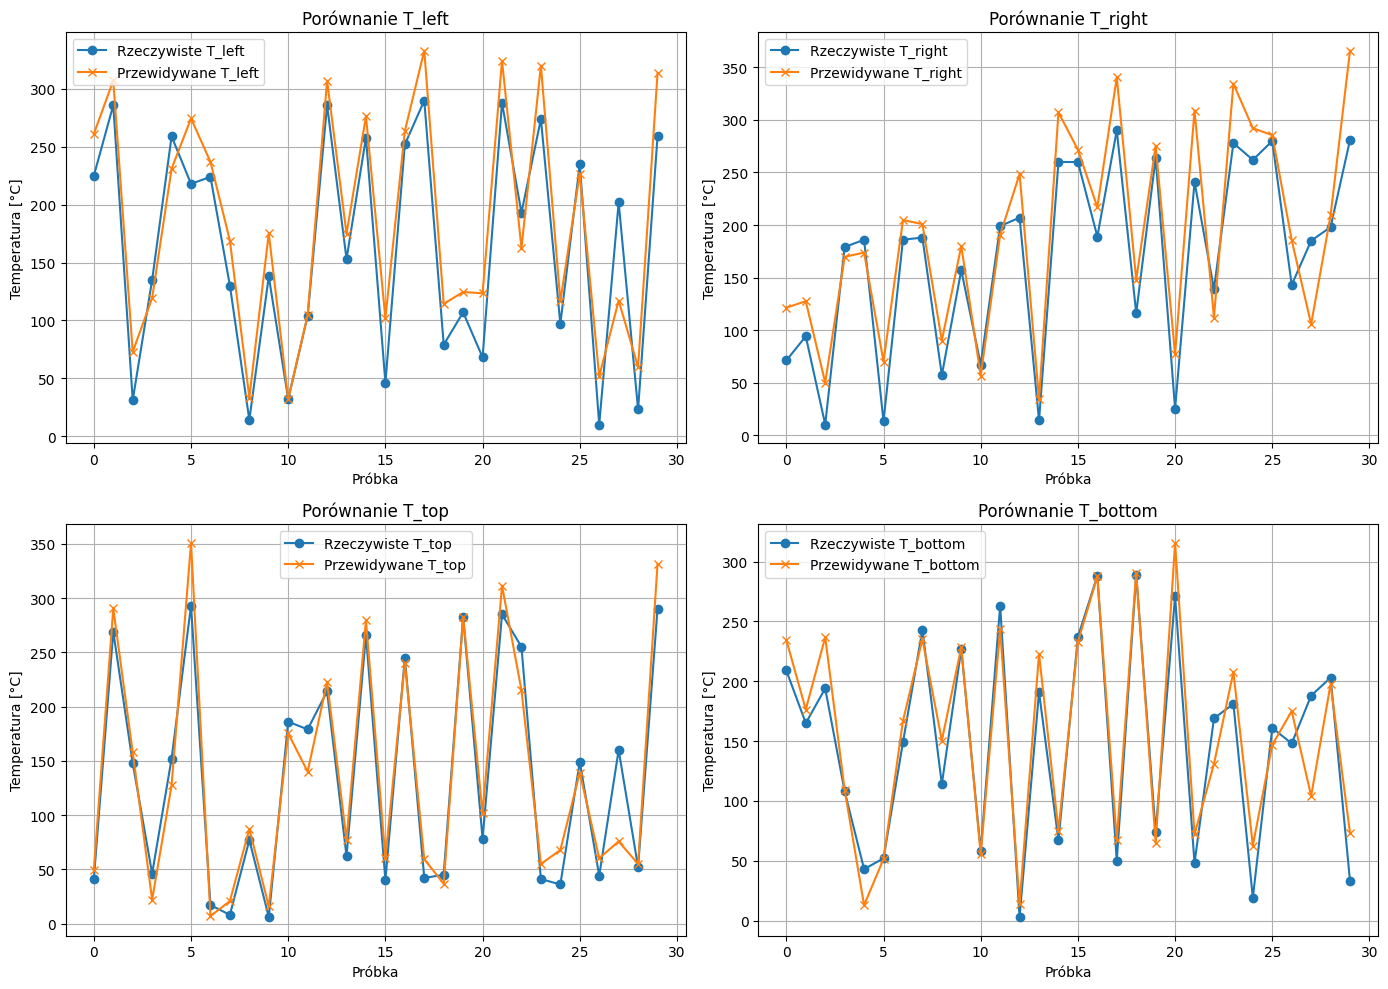

In [37]:
# Komórka 11: Wykresy - porównanie przewidywanych i rzeczywistych warunków brzegowych (BACK 2D)

# Przewidywanie warunków brzegowych dla danych testowych
y_pred_back_2D = model_back_2D.predict(X_test_back_2D, verbose=0)

# Lista etykiet warunków brzegowych
boundary_labels = ['T_left', 'T_right', 'T_top', 'T_bottom']

# Tworzenie wykresów
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, ax in enumerate(axes.flatten()):
    ax.plot(y_test_back_2D[:, i], label=f'Rzeczywiste {boundary_labels[i]}', marker='o')
    ax.plot(y_pred_back_2D[:, i], label=f'Przewidywane {boundary_labels[i]}', marker='x')
    ax.set_title(f'Porównanie {boundary_labels[i]}')
    ax.set_xlabel('Próbka')
    ax.set_ylabel('Temperatura [°C]')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


### Można spróbować ulepszyć

In [38]:
# Komórka 12: Próba ulepszenia modelu BACK 2D

from sklearn.preprocessing import StandardScaler

# 1. Normalizacja wyjść (warunki brzegowe)
y_scaler_back_2D = StandardScaler()
y_data_back_2D_scaled = y_scaler_back_2D.fit_transform(y_data_back_2D)

# Ponowny podział danych (z nowym y)
X_train_back_2D, X_test_back_2D, y_train_back_2D, y_test_back_2D = train_test_split(
    X_data_back_2D_scaled, y_data_back_2D_scaled, test_size=0.2, random_state=42
)

# 2. Nowy model ulepszony
improved_model_back_2D = keras.Sequential([
    lyr.Input(shape=(Nx * Ny,)),
    lyr.Dense(1024, activation='relu'),   # Więcej neuronów
    lyr.Dense(512, activation='relu'),
    lyr.Dense(256, activation='relu'),
    lyr.Dense(128, activation='relu'),
    lyr.Dense(4)                           # Wyjście: 4 warunki brzegowe
])

# 3. Kompilacja modelu z mniejszym learning rate
improved_model_back_2D.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='mae'
)

# 4. EarlyStopping
early_stopping_improved_back_2D = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

# 5. Trening ulepszonego modelu
history_improved_back_2D = improved_model_back_2D.fit(
    X_train_back_2D, y_train_back_2D,
    validation_split=0.1,
    epochs=500,      # Trochę więcej epok, ale zatrzyma się przez EarlyStopping
    batch_size=4,
    callbacks=[early_stopping_improved_back_2D],
    verbose=1
)

# 6. Ocena modelu na zbiorze testowym (po skalowaniu)
test_loss_improved_back_2D = improved_model_back_2D.evaluate(X_test_back_2D, y_test_back_2D, verbose=1)
print(f"Średni błąd bezwzględny (MAE) na zbiorze testowym (ulepszony BACK 2D - skalowane): {test_loss_improved_back_2D:.6f}")

# 7. Odwrócenie skalowania dla predykcji
y_pred_back_2D_scaled = improved_model_back_2D.predict(X_test_back_2D, verbose=0)
y_pred_back_2D = y_scaler_back_2D.inverse_transform(y_pred_back_2D_scaled)

# 8. Odwrócenie skalowania danych testowych dla porównania
y_test_back_2D_true = y_scaler_back_2D.inverse_transform(y_test_back_2D)

# 9. Szybka ocena rzeczywistego MAE na danych nieskalowanych
real_mae = np.mean(np.abs(y_test_back_2D_true - y_pred_back_2D))
print(f"Średni błąd bezwzględny (MAE) na rzeczywistych danych (BACK 2D v2): {real_mae:.6f}")


Epoch 1/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.5625 - val_loss: 0.3783
Epoch 2/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3071 - val_loss: 0.3060
Epoch 3/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2618 - val_loss: 0.2429
Epoch 4/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2118 - val_loss: 0.1963
Epoch 5/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2137 - val_loss: 0.2300
Epoch 6/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2440 - val_loss: 0.1607
Epoch 7/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1834 - val_loss: 0.1972
Epoch 8/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2016 - val_loss: 0.3180
Epoch 9/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2545 - val_loss: 0.1456
Epoch 10/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1572 - val_loss: 0.2210
Epoch 11/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1788 - val_loss: 0.2070
Epoch 12/500
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

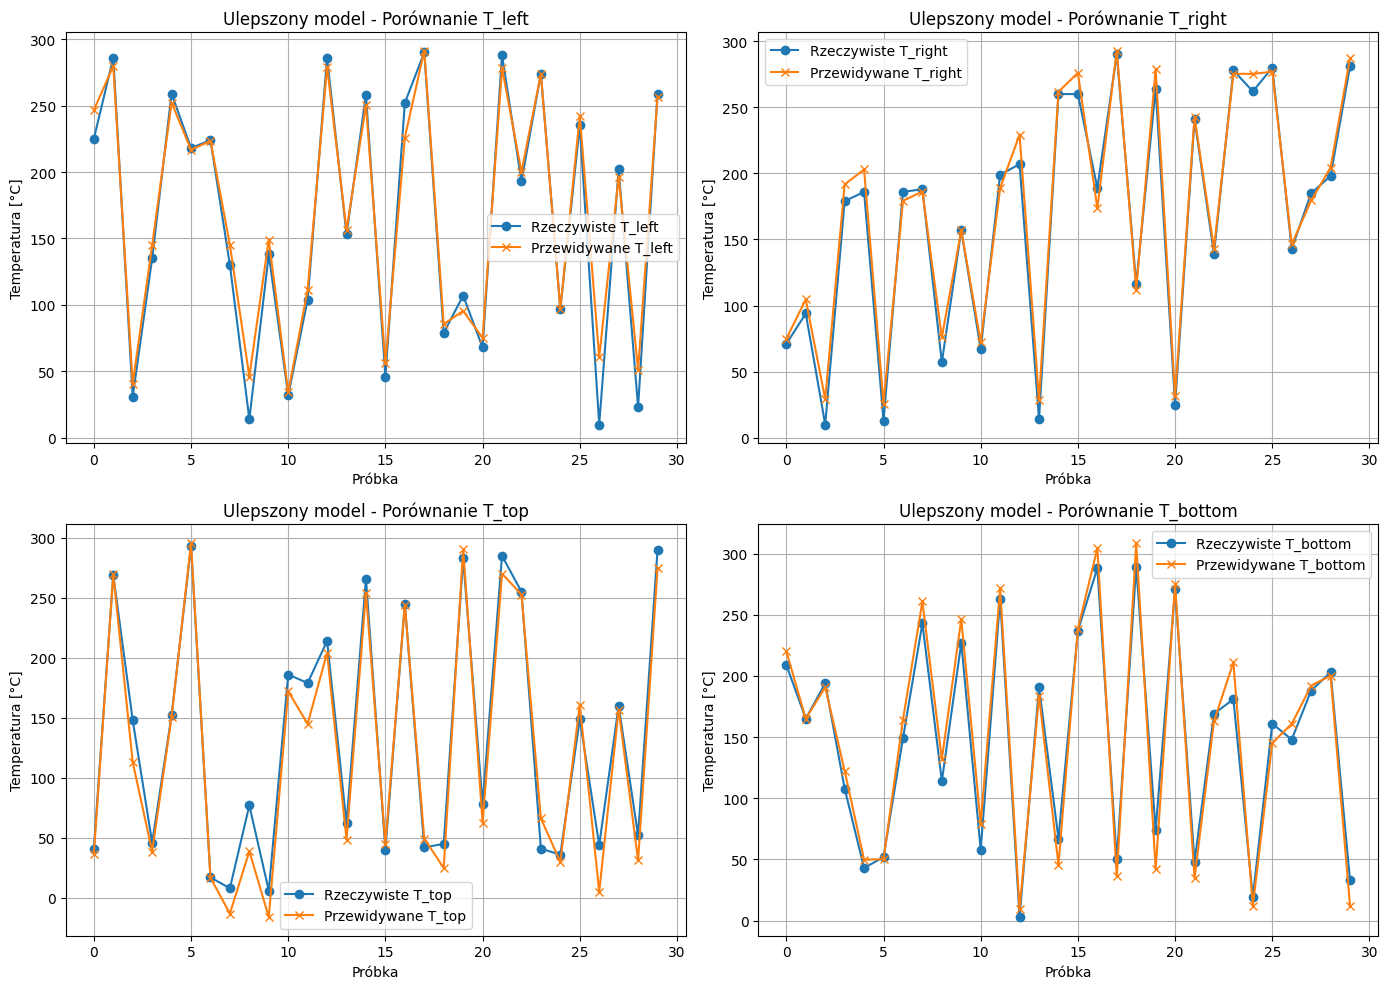

In [39]:
# Komórka 13: Wizualizacja wyników ulepszonego modelu BACK 2D

# Lista etykiet warunków brzegowych
boundary_labels = ['T_left', 'T_right', 'T_top', 'T_bottom']

# Tworzenie wykresów
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, ax in enumerate(axes.flatten()):
    ax.plot(y_test_back_2D_true[:, i], label=f'Rzeczywiste {boundary_labels[i]}', marker='o')
    ax.plot(y_pred_back_2D[:, i], label=f'Przewidywane {boundary_labels[i]}', marker='x')
    ax.set_title(f'Ulepszony model - Porównanie {boundary_labels[i]}')
    ax.set_xlabel('Próbka')
    ax.set_ylabel('Temperatura [°C]')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
